In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.prompt { display:none !important; }</style>"))

In [2]:
from ipyleaflet import Map
basic_map = Map(zoom = 1)
basic_map

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [3]:
import gpxpy
#gpx_file_path = 'Gran_Fondo_Porto_SantElpidio_2022.gpx'
gpx_file_path = 'Cesena_Fontanella_Pantani_Sorrivoli_Centenara_Cesena.gpx'

with open(gpx_file_path) as fh:
    gpxFile = gpxpy.parse(fh)

In [4]:
from statistics import mean
#import ipyleaflet
from ipyleaflet import basemaps, FullScreenControl, LayerGroup, \
    MeasureControl, Polyline, Marker, CircleMarker, WidgetControl
from ipywidgets import Button, HTML, HBox, VBox, Checkbox, FileUpload, \
    Label, Output, IntSlider, Layout, Image, link
from bqplot import pyplot as plt
from bqplot import *

In [5]:
#def plot_map(gpx):
"""
Plot the GPS trace on a map
"""
from ipyleaflet import Map

points = [p.point for p in gpxFile.get_points_data(distance_2d=True)]
mean_lat = mean(p.latitude for p in points)
mean_lng = mean(p.longitude for p in points)

# create the map
m = Map(center=(mean_lat, mean_lng), zoom=12, basemap=basemaps.Stamen.Terrain)

# show trace
line = Polyline(locations=[[[p.latitude, p.longitude] for p in points],],
                color = "red", fill=False)
m.add_layer(line)

# add markers
waypoints = [
    Marker(location=(point.latitude, point.longitude), title=point.name,
           popup=HTML(value=point.name), draggable=False)
    for point in gpxFile.waypoints
]
waypoints_layer = LayerGroup(layers=waypoints)
#m.add_layer(waypoints_layer)

# add a checkbox to show / hide waypoints
waypoints_checkbox = Checkbox(value=True, description='Show Waypoints')

def update_visible(change):
    for p in waypoints:
        p.visible = change['new']

waypoints_checkbox.observe(update_visible, 'value')
waypoint_control = WidgetControl(widget=waypoints_checkbox, position='bottomright')
m.add_control(waypoint_control)

# enable full screen mode
m.add_control(FullScreenControl())

# add measure control
measure = MeasureControl(
    position='bottomleft',
    active_color = 'orange',
    primary_length_unit = 'kilometers'
)
m.add_control(measure)

#return m
m

Map(center=[44.079069151812824, 12.218333058224683], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [6]:
# https://www.youtube.com/watch?v=jAKUPm-Cul0
#j = 90
#gpxFile.get_points_data(distance_2d=True)[j]#.tracks().segments[j]

In [7]:
#def plot_elevation(gpx):
"""
Return an elevation graph for the given gpx trace
"""
points = gpxFile.get_points_data(distance_2d=True)
px = [p.distance_from_start / 1000 for p in points]
py = [p.point.elevation for p in points]

x_scale, y_scale = LinearScale(), LinearScale()
x_scale.allow_padding = False
x_ax = Axis(label='Distance (km)', scale=x_scale)
y_ax = Axis(label='Elevation (m)', scale=y_scale, orientation='vertical')

lines = Lines(x=px, y=py, scales={'x': x_scale, 'y': y_scale})

u = 90
elevation = Figure(title='Elevation Chart %d' %u, axes=[x_ax, y_ax], marks=[lines])


elevation.layout.width = 'auto'
elevation.layout.height = 'auto'
elevation.layout.min_height = '300px'

#elevation.interaction = IndexSelector(scale=x_scale)
#return elevation
elevation

Figure(axes=[Axis(label='Distance (km)', scale=LinearScale(allow_padding=False)), Axis(label='Elevation (m)', …

In [8]:
import pandas as pd

j = 0
points = []
for segment in gpxFile.tracks[j].segments:
    for p in segment.points:
        points.append({
            'time': p.time,
            'latitude': p.latitude,
            'longitude': p.longitude,
            'elevation': p.elevation,
        })
coords = pd.DataFrame.from_records(points)

In [9]:
#to convert pandas datetime into a integer of seconds
from datetime import datetime

timeList = [ datetime.timestamp( u ) for u in coords['time'] ]
DeltaTime = np.diff(timeList)
DeltaTime = np.append([0], DeltaTime)
coords['DeltaTime'] = pd.Series( DeltaTime )

DeltaLat = np.diff( coords['latitude'] )*111.139e3

DeltaLong = np.diff( coords['longitude'] )*111.139e3

DeltaElev = np.diff( coords['elevation'] )

DeltaSpace = ( DeltaLat**2 + DeltaLong**2 + DeltaElev**2 )**.5

coords['DeltaSpace'] = pd.Series( DeltaSpace )
coords['DeltaSpace'].replace([np.inf, -np.inf], np.nan, inplace=True)

coords['speed'] = 3.6*coords['DeltaSpace']/coords['DeltaTime']
coords['speed'].replace([np.inf, -np.inf], np.nan, inplace=True)
coords.head()

,time,latitude,longitude,elevation,DeltaTime,DeltaSpace,speed
0,2022-10-02 15:13:49+00:00,44.140379,12.238573,34.0,0.0,5.172216,NaN
1,2022-10-02 15:13:50+00:00,44.140386,12.238527,33.9,1.0,8.741073,31.467864
2,2022-10-02 15:13:52+00:00,44.140402,12.238450,33.8,2.0,3.972826,7.151087
3,2022-10-02 15:13:53+00:00,44.140413,12.238416,33.7,1.0,6.398759,23.035534
4,2022-10-02 15:13:55+00:00,44.140430,12.238361,33.6,2.0,8.632295,15.538132


In [11]:
#in a bike gpx track, a difference of speeds of 10 km/h or more in between two gps points
#is highly unreasonable. Here points showing such a speed difference are discarted
diffSpeed = np.diff(coords['speed'])
maxSpeedDiff = 10
#speed difference excess indexes
inLayers = np.where( abs( diffSpeed ) < maxSpeedDiff )[0] 
outLayers = np.where( abs( diffSpeed ) > maxSpeedDiff )[0]

<IPython.core.display.Javascript object>


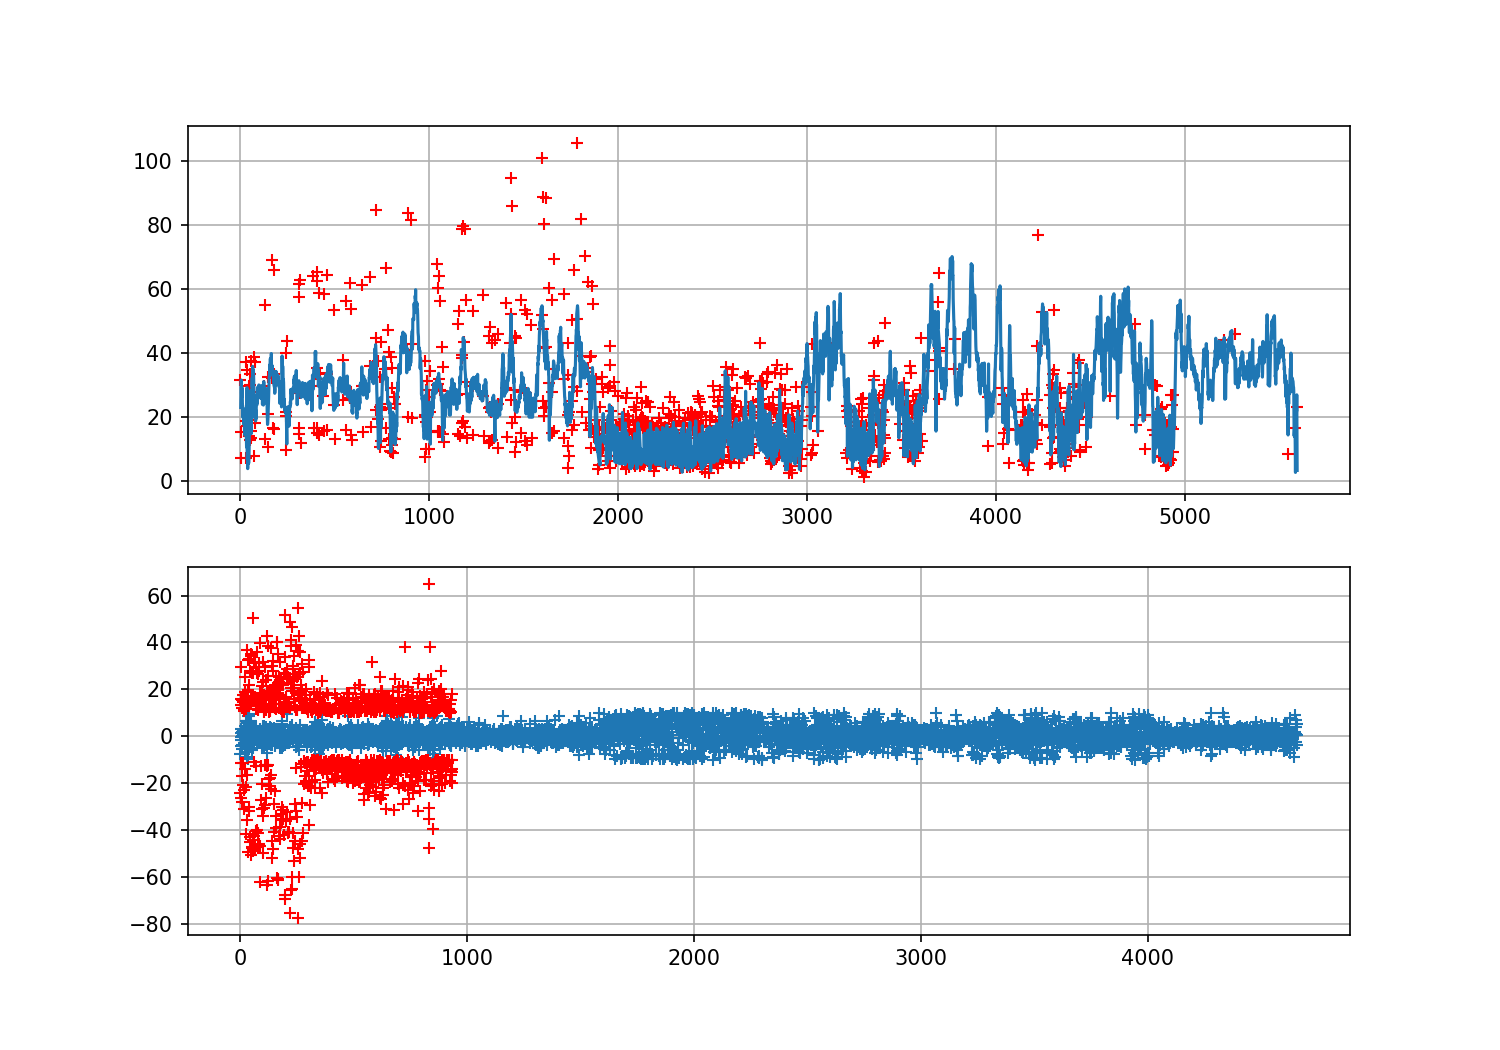

In [23]:
import matplotlib.pyplot as mp
%matplotlib notebook

mp.figure(figsize=(10,7))
mp.subplot(211)
mp.plot(coords['speed'][outLayers], 'r+')
mp.plot(coords['speed'][inLayers])#, 'b--')
mp.grid()

mp.subplot(212)
mp.plot(diffSpeed[inLayers], '+')
mp.plot(diffSpeed[outLayers], 'r+')
mp.grid()
mp.show()

In [ ]:
speed = []
for j in range(100):
    speed = speed + [ coords['speed'][ 10*j : 9*(j+1) ].mean() ]
    print(coords['speed'][ 10*j : 9*(j+1) ])

In [ ]:
mp.figure()
mp.grid()
mp.plot(speed)
mp.show()

In [ ]:
mp.figure()
mp.plot( coords['DeltaSpace'], '+')#[940:]
mp.grid()
mp.show()